In [1]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
from sklearn.preprocessing import normalize
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import plotly.graph_objs as go
import plotly.tools as tls
import os
import sklearn.metrics.pairwise as cosine
from sklearn.calibration import CalibratedClassifierCV
import gc
from sklearn.metrics import classification_report
from sklearn.linear_model import SGDClassifier
from fuzzywuzzy import fuzz
from scipy.sparse import hstack
import scipy
from prettytable import PrettyTable
import re
from nltk.corpus import stopwords
import distance
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from wordcloud import WordCloud, STOPWORDS
from os import path
from sklearn.model_selection import train_test_split
from PIL import Image
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import RandomizedSearchCV
from mlxtend.classifier import StackingClassifier
from keras.layers.normalization import BatchNormalization 
from keras.preprocessing import sequence 
from keras.models import Sequential 
from keras.layers import Dense, Dropout, Embedding, LSTM 
 

Using TensorFlow backend.


In [2]:
#Get information of a data
def getDataInsights(data):
    #1. Total no of data points
    print('\x1b[1;03;55;55m')
    print("Total no of data points=", data.shape[0] ,"and feature =", data.shape[1])


    #2. Find feature data type 
    print("\n")
    print("Types of each feature")
    print("---------------------")
    print(data.dtypes)

    #Let  us check if there exist any missing values
    print("\n")
    print("Find null entries per feature")
    print("--------------------------------")
    print(data.isnull().sum())


    print("\n")
    print("Find unique data")
    print(data.apply(pd.Series.nunique))


    #let us have a glimpse of data 
    print(data.head())

def findClassDistribution():
    plt.figure(figsize=(10,5))
    sns.countplot(x='is_duplicate', data=df,palette='spring_r')
    plt.ylabel('Distribution of labels')
    plt.xlabel('Classes')
    plt.title('Distribution of duplicate labels in train data')

    plt.legend();
    plt.show();


    print('\x1b[1;03;55;55m')
    print("Distribution of YValues")
    col_name="is_duplicate"
    values_count_tr = pd.DataFrame(df[col_name].value_counts())    
    values_count_tr.columns = ['count'] 
    values_count_tr[col_name] = [ str(i) for i in values_count_tr.index ]
    values_count_tr['percent'] = values_count_tr['count'].div(values_count_tr['count'].sum()).multiply(100).round(2) 

    x =  PrettyTable(header_style='upper', padding_width=2)     
    for col in values_count_tr.columns:
        x.add_column(column=values_count_tr[col],fieldname=col)
    print(x)  

def FindMostRepeatedQuestions(data,col_name,n):
    values_count = pd.DataFrame(data[col_name].value_counts().head(n))    
    values_count.columns = ['count'] 
    values_count[col_name] = [ str(i) for i in values_count.index ]
    values_count['percent'] = values_count['count'].div(values_count['count'].sum()).multiply(100).round(2) 
    values_count = values_count.reindex_axis([col_name,'count','percent'],axis=1)
    values_count.reset_index(drop=True,inplace=True) 
    x =  PrettyTable(header_style='upper', padding_width=1)     
    for col in values_count.columns:
        x.add_column(column=values_count[col],fieldname=col)
    print(x)
    
def buildModel(train_x,test_x,name,train_y,test_y):
    print('\x1b[1;03;55;55m')
    modelAnalysis = {"Alpha":[], "LogLoss":[]}   
    alpha = [10 ** x for x in range(-5, 2)]
    cv_log_error_array = []
    for i in alpha:
        modelAnalysis["Alpha"].append(i)       
        if(name=="LogRegBalance"):
            clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
            clf.fit(train_x, train_y)
        if(name=="LogReg"):
            clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
            clf.fit(train_x, train_y)
        if(name=="SVM"):
            clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
            clf.fit(train_x, train_y)
             
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x, train_y)
        sig_clf_probs = sig_clf.predict_proba(test_x)
        cv_log_error_array.append(log_loss(test_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        # to avoid rounding error while multiplying probabilites we use log-probability estimates
        modelAnalysis["LogLoss"].append(log_loss(test_y, sig_clf_probs)) 
    
    x =  PrettyTable(header_style='upper', padding_width=5)  
    modelAnalysis=pd.DataFrame(modelAnalysis)
    for col in modelAnalysis.columns:
        x.add_column(column=modelAnalysis[col],fieldname=col)
    print(x)   
    fig, ax = plt.subplots()
    ax.plot(alpha, cv_log_error_array,c='g')
    for i, txt in enumerate(np.round(cv_log_error_array,3)):
        ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
    plt.grid()
    plt.title("Cross Validation Error for each alpha")
    plt.xlabel("Alpha i's")
    plt.ylabel("Error measure")
    plt.show()

    print('\x1b[1;03;55;55m')
    best_alpha = np.argmin(cv_log_error_array)
    clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)

    predict_y = sig_clf.predict_proba(train_x)
    print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15))
#     predict_y = sig_clf.predict_proba(cv_x)
#     print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    predict_y = sig_clf.predict_proba(test_x)
    print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15))
    print("Best alpha for model ",name ,"is ",alpha[best_alpha])
    plot_confusion_matrix(test_y, predicted_y)
    return   alpha[best_alpha],clf

# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap='BuPu', fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap='BuPu', fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap='BuPu', fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

#CODE REFERENCE :https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
def fitXGBoost(alg, dtrain,dtest,y_train,y_test):
    print('\x1b[1;03;55;55m') 
    xgb_param = alg.get_xgb_params() 
    xgtrain = xgb.DMatrix(dtrain, label=y_train)
    cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=5, metrics='logloss', early_stopping_rounds=50)
    alg.set_params(n_estimators=cvresult.shape[0])
    alg.fit(dtrain, y_train,eval_metric='logloss')
    
    dtrain_predictions = alg.predict(dtrain)
    dtrain_predprob = alg.predict_proba(dtrain)[:,1]
    
    dtest_predictions = alg.predict(dtest)
    dtest_predprob = alg.predict_proba(dtest)[:,1]
    
    print ("LogLoss Train: %f" % metrics.log_loss(y_train, dtrain_predprob))
    print ("LogLoss Test: %f" % metrics.log_loss(y_test, dtest_predprob))
    plot_confusion_matrix(predict_y=dtest_predictions,test_y=y_test)
    
    return alg

def addBasicFeatures(temp):
    temp['freq_qid1'] = temp.groupby('qid1')['qid1'].transform('count') 
    temp['freq_qid2'] = temp.groupby('qid2')['qid2'].transform('count')
    temp['q1len'] = temp['question1'].str.len() 
    temp['q2len'] = temp['question2'].str.len()
    temp['q1_n_words'] = temp['question1'].apply(lambda row: len(row.split(" ")))
    temp['q2_n_words'] = temp['question2'].apply(lambda row: len(row.split(" ")))
    temp['word_Common'] = temp.apply(normalized_word_Common, axis=1)
    temp['word_share'] = temp.apply(normalized_word_share, axis=1)
    temp['word_Total'] = temp.apply(normalized_word_Total, axis=1)
    temp['freq_q1+q2'] = temp['freq_qid1']+temp['freq_qid2']
    temp['freq_q1-q2'] = abs(temp['freq_qid1']-temp['freq_qid2'])
    
def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)
    

def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
   
def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
   

In [4]:
df = pd.read_csv("train.csv")

<h2> 1. Basic Tasks</h2>
<ol>
<li> Get data insights
<li> Check null values
<li> Find class label disctribution
<li> Find duplicate question pairs 
<li> Find most repeated question
</ol>


In [4]:
#1 Get data insights 
getDataInsights(df)


Total no of data points= 404290 and feature = 6


Types of each feature
---------------------
id               int64
qid1             int64
qid2             int64
question1       object
question2       object
is_duplicate     int64
dtype: object


Find null entries per feature
--------------------------------
id              0
qid1            0
qid2            0
question1       0
question2       2
is_duplicate    0
dtype: int64


Find unique data
id              404290
qid1            290654
qid2            299364
question1       290457
question2       299174
is_duplicate         2
dtype: int64
   id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve

<h4> Takeaways..</h4>
<b>
<ul>
<li> Id is the unique key
<li> there exist 2 null entries in question 2 - train dataset
<li> Question 1 has 290457 unique entries out of 404290
</ul>
<br>
<br>
We will remove  the null value question from the train data- as it is of no use

In [5]:
#2 Check null values 
null_Rows=df[df.isnull().any(1)]
null_Rows


,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0


In [6]:
df=df.dropna()
print("Null values in train",df[df.isnull().any(1)].shape )


Null values in train (0, 6)


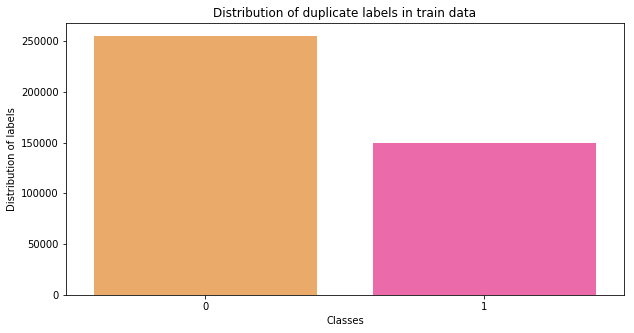


Distribution of YValues
+----------+----------------+-----------+
|  COUNT   |  IS_DUPLICATE  |  PERCENT  |
+----------+----------------+-----------+
|  255025  |       0        |   63.08   |
|  149263  |       1        |   36.92   |
+----------+----------------+-----------+


In [10]:
#3 Find class label disctribution 
findClassDistribution()

<b>
We have around 60 - 40 ratio for unique and duplicated question pairs respectively

In [188]:
#4 Find duplicate question pairs 
print('\x1b[1;03;55;55m')
pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

print ("Number of duplicate questions",(pair_duplicates).shape[0] - df.shape[0])


Number of duplicate questions 0


In [9]:
#5 Find most repeated questions 

print('Top 5 most asked question1 in train data')
FindMostRepeatedQuestions(df,'question1',5)

print('Top 5 most asked question2 in train data')
FindMostRepeatedQuestions(df,'question2',5)

Top 5 most asked question1 in train data
+--------------------------------------------------------------------------------------------+-------+---------+
|                                         QUESTION1                                          | COUNT | PERCENT |
+--------------------------------------------------------------------------------------------+-------+---------+
|                           How do I improve my English speaking?                            |   50  |  20.92  |
| How does the ban on 500 and 1000 rupee notes helps to identify black money and corruption? |   48  |  20.08  |
|          How can changing 500 and 1000 rupee notes end the black money in India?           |   47  |  19.67  |
|                           How do I improve my English language?                            |   47  |  19.67  |
|                           What should I do to earn money online?                           |   47  |  19.67  |
+------------------------------------------------------

<h2>2. Basic feature transform</h2>


Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [8]:
addBasicFeatures(df)

In [9]:
getDataInsights(df)


Total no of data points= 404288 and feature = 17


Types of each feature
---------------------
id                int64
qid1              int64
qid2              int64
question1        object
question2        object
is_duplicate      int64
freq_qid1         int64
freq_qid2         int64
q1len             int64
q2len             int64
q1_n_words        int64
q2_n_words        int64
word_Common     float64
word_share      float64
word_Total      float64
freq_q1+q2        int64
freq_q1-q2        int64
dtype: object


Find null entries per feature
--------------------------------
id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
freq_qid1       0
freq_qid2       0
q1len           0
q2len           0
q1_n_words      0
q2_n_words      0
word_Common     0
word_share      0
word_Total      0
freq_q1+q2      0
freq_q1-q2      0
dtype: int64


Find unique data
id              404288
qid1            290653
qid2            299363
question1 

In [12]:
print ("Minimum length of the questions in question1 : " , min(df['q1_n_words']))
print ("Minimum length of the questions in question2 : " , min(df['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 67
Number of Questions with minimum length [question2] : 22


<h2>3. Univariate analysis of derived feature</h2>
<ol>
<li>Preprocess text data 
    <ul>
    <li> Removing html tags 
    <li> Removing Punctuations
    <li> Performing stemming
    <li> Removing Stopwords
    <li> Expanding contractions etc.
    </ul>
<li>Add advanced derived features from fuzzywuzzy library 
</ol>

In [10]:
# To get the results in 4 decemal points
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

#     print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
#     Computing Fuzzy Features and Merging with Dataset
    
#     do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
#     https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
#     https://github.com/seatgeek/fuzzywuzzy
#     print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [11]:
print("Extracting features:")
df = extract_features(df)
# df.to_csv("nlp_features_train.csv", index=False)
df.head(2)

Extracting features:


,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,4,1,51,88,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


<h2>4. Univariate analysis of derived feature</h2>
<ol>
<li>Check impact of derived feature on the class label
<li>Analyse WordCommon
<li>Analyse Word Total
<li>Analyse Word share  
</ol>

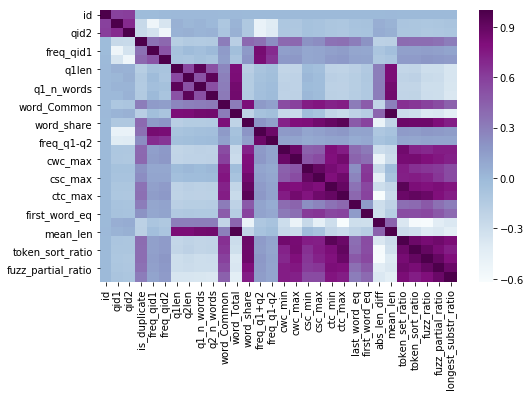

In [15]:
#1. Check impact of derived feature on the class label 
plt.figure(figsize=(8,5))
sns.heatmap(data=df.corr(method='spearman'),cmap='BuPu')
plt.show()

<b>
Takeaways
- frequencies, word common and word share - affects the class label 

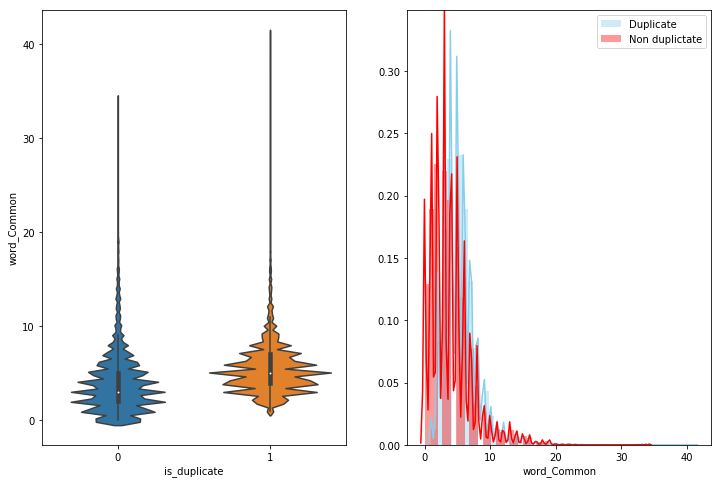

In [16]:
#2. Analyse Word common feature
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = df[0:])

plt.subplot(1,2,2)
sns.distplot( df[df['is_duplicate'] == 1.0]['word_Common'][0:] , color="skyblue", label="Duplicate")
sns.distplot( df[df['is_duplicate'] == 0.0]['word_Common'][0:] , color="red", label="Non duplictate")
plt.legend()
 

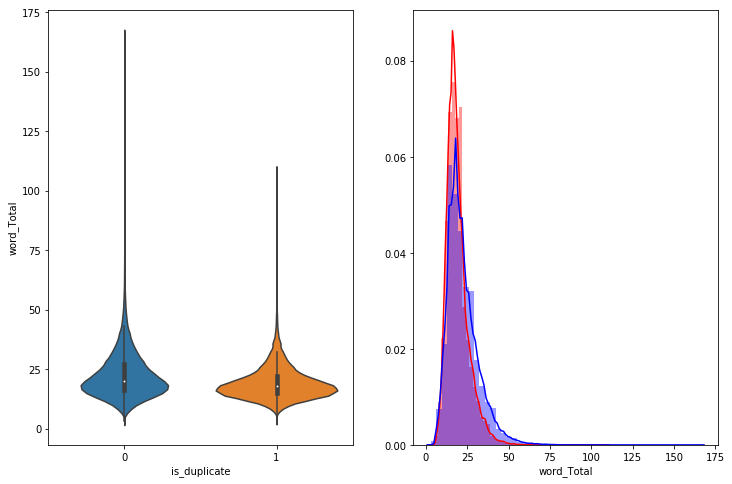

In [17]:
#3. Analyse Word total feature
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Total', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Total'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Total'][0:] , label = "0" , color = 'blue' )
plt.show()

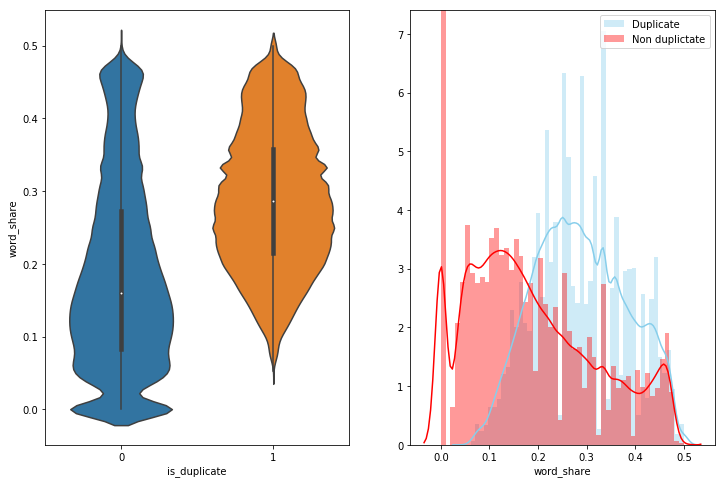

In [18]:
#4. Analyse Word Share feature
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:])

plt.subplot(1,2,2)
sns.distplot( df[df['is_duplicate'] == 1.0]['word_share'][0:] , color="skyblue", label="Duplicate")
sns.distplot( df[df['is_duplicate'] == 0.0]['word_share'][0:] , color="red", label="Non duplictate")
plt.legend()


<h2>5. Plot wordclouds for duplicate and non duplicate classes</h2>

In [19]:
df_duplicate = df[df['is_duplicate'] == 1]
dfp_nonduplicate = df[df['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))



Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510050


In [20]:
# reading the text files and removing the Stop Words:
d = path.dirname('.')

textp_w = open(path.join(d, 'train_p.txt')).read()
textn_w = open(path.join(d, 'train_n.txt')).read()
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")
#stopwords.remove("good")
#stopwords.remove("love")
stopwords.remove("like")
#stopwords.remove("best")
#stopwords.remove("!")
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 891343
Total number of words in non duplicate pair questions : 33193130


Word Cloud for Duplicate Question pairs


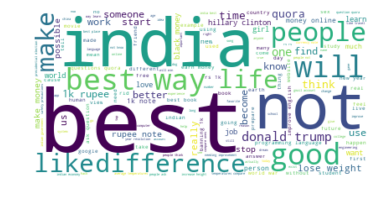

In [21]:
wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Word Cloud for Duplicate Question pairs


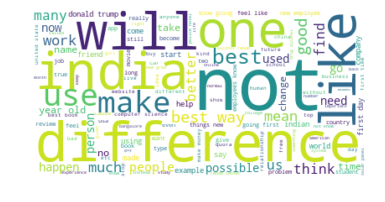

In [147]:
wc = WordCloud(background_color="white", max_words=len(textn_w), stopwords=stopwords)
wc.generate(textn_w)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

<h2>6. Create TFIDF vector of questions </h2>

In [12]:
# df=df.sample(n=100000)
temp=df.copy()
df=df.sample(100000)

In [13]:
y_true = df['is_duplicate']
X_train,X_test, y_train, y_test = train_test_split(df, y_true, stratify=y_true, test_size=0.3)

In [12]:

print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in test data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[0])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6309428571428571 Class 1:  0.36905714285714286
---------- Distribution of output variable in test data ----------
Class 0:  0.6309333333333333 Class 1:  0.36906666666666665


In [14]:

questions = list(X_train['question1']) + list(X_train['question2'])

tfidf = TfidfVectorizer(lowercase=False)
tfidf.fit_transform(questions)

final_tf_idf_train_q1 = tfidf.transform(X_train['question1'].values) 
final_tf_idf_train_q2= tfidf.transform(X_train['question2'].values) 
final_tf_idf_test_q1 = tfidf.transform(X_test['question1'].values) 
final_tf_idf_test_q2= tfidf.transform(X_test['question2'].values) 
#Normalize the data
train_normalize_q1 = normalize(final_tf_idf_train_q1, axis=0) 
train_normalize_q2 = normalize(final_tf_idf_train_q2, axis=0) 
test_normalize_q1 = normalize(final_tf_idf_test_q1, axis=0) 
test_normalize_q2 = normalize(final_tf_idf_test_q2, axis=0) 

<h2>7. Find cosine distance bwtween 2 questions </h2>

In [15]:
csrq1=train_normalize_q1.tocsr()
csrq2=train_normalize_q2.tocsr()
 
cosineTrain=[]
for i in range(0,csrq2.shape[0]):
    cosineTrain.append(cosine.cosine_similarity(csrq1[i],csrq2[i])[0][0]) 

testcsrq1=test_normalize_q1.tocsr()
testcsrq2=test_normalize_q2.tocsr()
 
cosineTest=[]
for i in range(0,testcsrq2.shape[0]):
    cosineTest.append(cosine.cosine_similarity(testcsrq1[i],testcsrq2[i])[0][0])

X_train['Cosine']=cosineTrain
X_test['Cosine']=cosineTest 

<h2>8. Find logloss of a dumb model</h2>

Log loss on Test Data using Random Model 0.8836153535648346


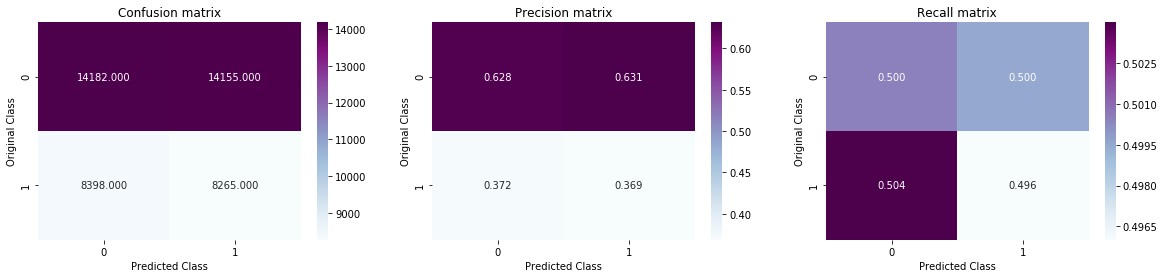

In [31]:
 
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

<h2>9. Build train and test for models </h2>

In [19]:
#Build model

#remove qid1,qid2, question1  and question2 from train and test data
X_train.drop(['id','is_duplicate','qid1','qid2','question1','question2'], axis=1, inplace=True)
X_test.drop(['id','is_duplicate','qid1','qid2','question1','question2'], axis=1, inplace=True)
# Stacking data
 
train_x= hstack((np.matrix(X_train),train_normalize_q1,train_normalize_q2)).tocsr()
test_x=hstack((np.matrix(X_test),test_normalize_q1,test_normalize_q2)).tocsr()


<h2>10. Try different models with the data </h2>


+----------------+-----------------------------+
|     ALPHA      |           LOGLOSS           |
+----------------+-----------------------------+
|     1e-05      |      0.4500594233574348     |
|     0.0001     |      0.4506449721198247     |
|     0.001      |     0.45108742365579085     |
|      0.01      |      0.4506323784574818     |
|      0.1       |      0.456913979627432      |
|      1.0       |      0.4881145405556511     |
|      10.0      |      0.532224147975459      |
+----------------+-----------------------------+


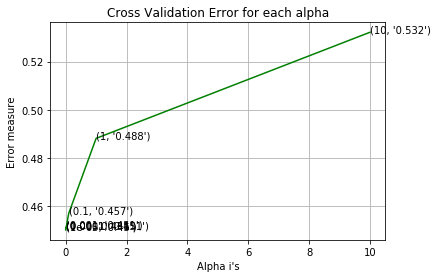


For values of best alpha =  1e-05 The train log loss is: 0.4463748639531332
For values of best alpha =  1e-05 The test log loss is: 0.4500594233574348
Best alpha for model  LogRegBalance is  1e-05


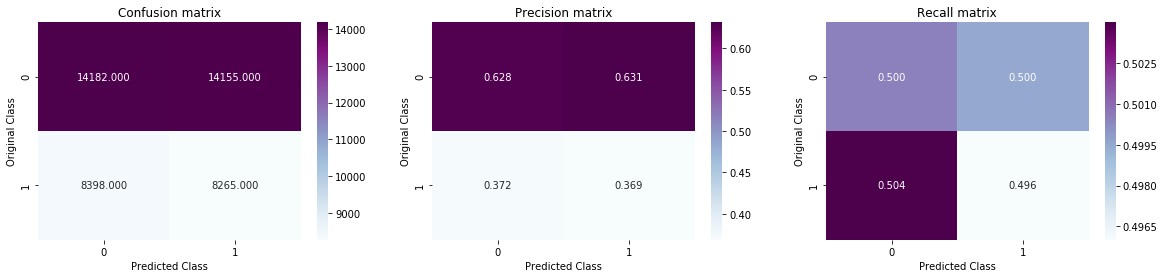

In [33]:
logregclassalpha,clf=buildModel(train_x,test_x,'LogRegBalance',y_train,y_test)


+----------------+-----------------------------+
|     ALPHA      |           LOGLOSS           |
+----------------+-----------------------------+
|     1e-05      |     0.45166196838174993     |
|     0.0001     |      0.4495412881918747     |
|     0.001      |      0.4515126210362158     |
|      0.01      |      0.4516804536718948     |
|      0.1       |      0.4601262262104506     |
|      1.0       |     0.49488294472987293     |
|      10.0      |      0.5441552553414074     |
+----------------+-----------------------------+


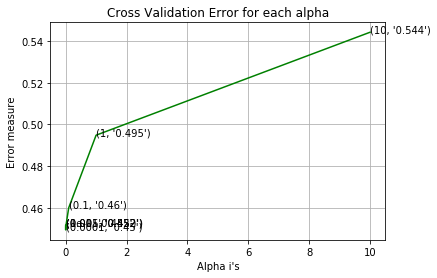


For values of best alpha =  0.0001 The train log loss is: 0.44706167293001253
For values of best alpha =  0.0001 The test log loss is: 0.4506449721198247
Best alpha for model  LogReg is  0.0001


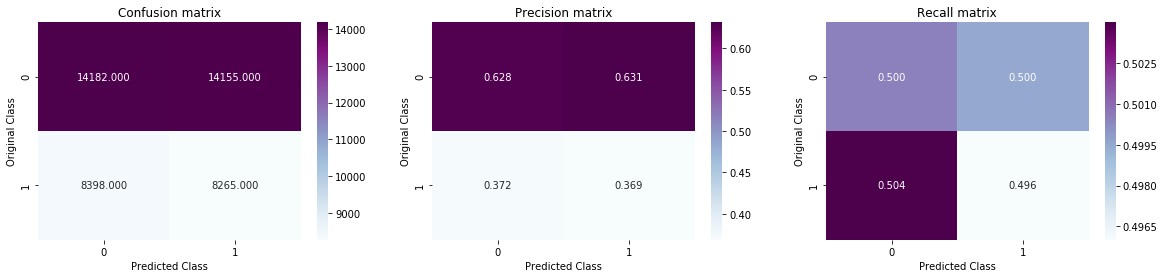

In [34]:
logregclassalpha,clf=buildModel(train_x,test_x,'LogReg',y_train,y_test)


+----------------+-----------------------------+
|     ALPHA      |           LOGLOSS           |
+----------------+-----------------------------+
|     1e-05      |      0.4512955723197899     |
|     0.0001     |      0.4496464305379157     |
|     0.001      |     0.45165181333292226     |
|      0.01      |      0.4517508689907697     |
|      0.1       |     0.45522208124989477     |
|      1.0       |      0.4791602090929057     |
|      10.0      |      0.5270052964575965     |
+----------------+-----------------------------+


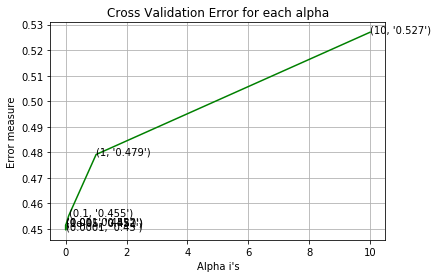


For values of best alpha =  0.0001 The train log loss is: 0.44706167293001253
For values of best alpha =  0.0001 The test log loss is: 0.4506449721198247
Best alpha for model  SVM is  0.0001


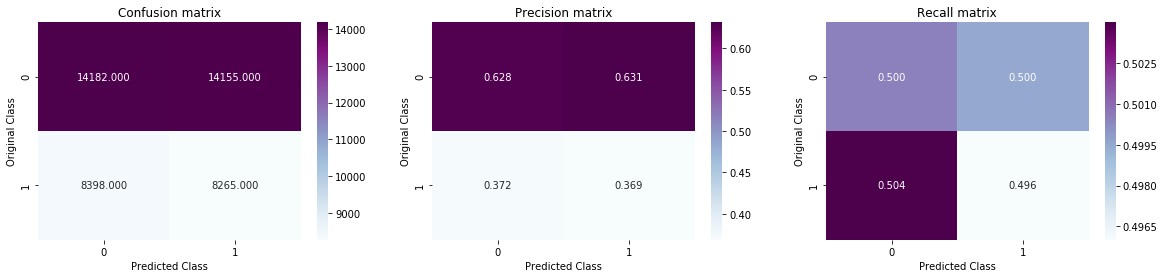

In [35]:
logregclassalpha,clf=buildModel(train_x,test_x,'SVM',y_train,y_test)

In [43]:

clf1 = SGDClassifier(alpha=0.00001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(train_x, y_train)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=0.0001, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x, y_train)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")

 
sig_clf1.fit(train_x, y_train)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(y_test, sig_clf1.predict_proba(test_x))))
sig_clf2.fit(train_x, y_train)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(y_test, sig_clf2.predict_proba(test_x))))
 
print("-"*50)
alpha = [0.00001,0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x, y_train)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(y_test, sclf.predict_proba(test_x))))
    log_error =log_loss(y_test, sclf.predict_proba(test_x))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 0.45
Support vector machines : Log Loss: 0.45
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000010 Log Loss: 0.645
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 0.538
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 0.464
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 0.456
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 0.455
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 0.454
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 0.454



LogLoss Train: 0.410512
LogLoss Test: 0.413064


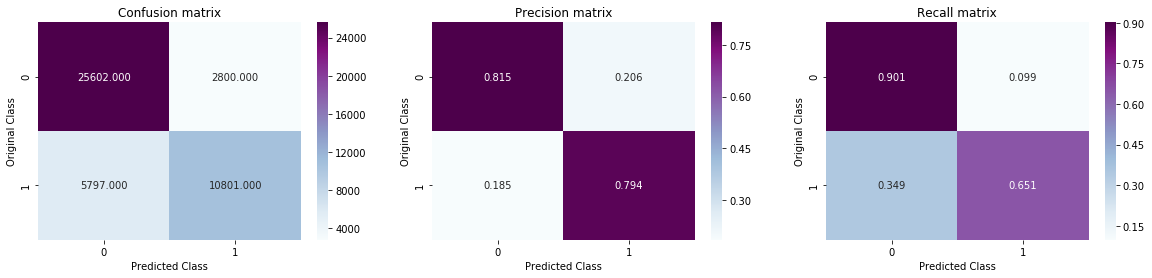

In [42]:

xgb1 = XGBClassifier(
 learning_rate =0.02,
 max_depth=4,
 objective= 'binary:logistic',)
alg=fitXGBoost(xgb1, train_x,test_x,y_train,y_test)  


In [46]:
# A parameter grid for XGBoost
  
params = {
        'min_child_weight': [1, 6, 2],
        'gamma': [i/10.0 for i in range(0,5)],
        'subsample': [0.5, 0.9, 1.0],
        'colsample_bytree': [0.5, 0.8, 1.0],
        'max_depth': [2, 3, 4, 5] 
        }
xgbclassifier = XGBClassifier(learning_rate=0.02, n_estimators=600,eval_metric='logloss', objective='binary:logistic',silent=False, nthread=1) 
random_search = RandomizedSearchCV(xgbclassifier, param_distributions=params, n_iter=5, n_jobs=6, cv=5, verbose=3, random_state=1001 ) 
random_search.fit(train_x, y_train) 

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed: 93.9min finished


[23:26:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:26:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:26:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:27:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:27:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:27:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:27:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[23:28:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:28:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[23:28:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:28:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:28:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:28:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:28:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[23:30:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[23:30:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[23:30:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 2 pruned nodes, max_depth=5
[23:30:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[23:30:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:30:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:30:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[23:32:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[23:32:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[23:32:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[23:32:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[23:32:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[23:32:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[23:32:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[23:33:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[23:33:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[23:33:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:33:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[23:34:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[23:34:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[23:34:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[23:35:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[23:35:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:35:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[23:35:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[23:35:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:35:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[23:35:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[23:37:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[23:37:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[23:37:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[23:37:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[23:37:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[23:37:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[23:37:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[23:39:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[23:39:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[23:39:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 2 pruned nodes, max_depth=5
[23:39:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 4 pruned nodes, max_depth=5
[23:39:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[23:39:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[23:39:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[23:40:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[23:40:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[23:40:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[23:40:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[23:41:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:41:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[23:41:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[23:42:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[23:42:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[23:42:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[23:42:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[23:42:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[23:42:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 2 pruned nodes, max_depth=5
[23:42:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[23:44:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:44:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[23:44:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[23:44:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[23:44:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[23:44:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[23:44:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='logloss', gamma=0,
       learning_rate=0.02, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=600, n_jobs=1,
       nthread=1, objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=False,
       subsample=1),
          fit_params=None, iid=True, n_iter=5, n_jobs=4,
          param_distributions={'min_child_weight': [1, 6, 2], 'gamma': [0.0, 0.1, 0.2, 0.3, 0.4], 'subsample': [0.5, 0.9, 1.0], 'colsample_bytree': [0.5, 0.8, 1.0], 'max_depth': [2, 3, 4, 5]},
          pre_dispatch='2*n_jobs', random_state=1001, refit=True,
          return_train_score='warn', scoring=None, verbose=3)

In [53]:
print("Best params")
print(random_search.best_params_) 

Best params
{'subsample': 0.9, 'min_child_weight': 2, 'max_depth': 5, 'gamma': 0.2, 'colsample_bytree': 0.8}



LogLoss Train: 0.328618
LogLoss Test: 0.345849


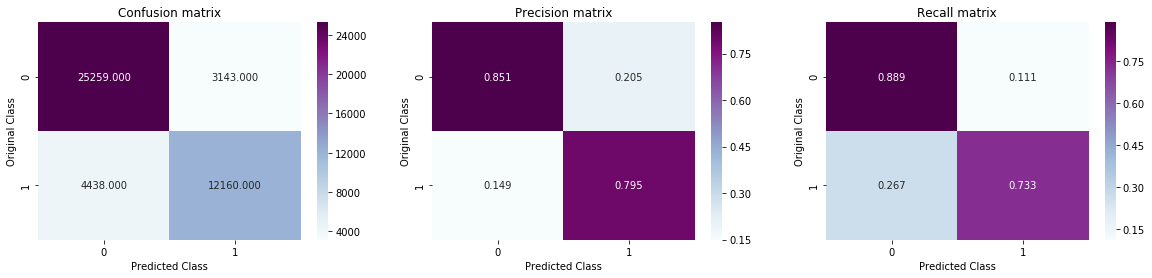

In [41]:
# 'subsample': 0.9, 'min_child_weight': 2, 'max_depth': 5, 'gamma': 0.2, 'colsample_bytree': 0.8}
xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=100,
 max_depth=5,
 min_child_weight=2,
 gamma=0.2,
 subsample=0.9,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
alg=fitXGBoost(xgb2, train_x,test_x,y_train,y_test) 


<h2>11. Check with LSTM </h2>

In [17]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
num_words = 20000
tokenizer = Tokenizer( num_words,lower=True, split=' ', char_level=False)
tokenizer.fit_on_texts(questions)
                       
                       
Q1 = tokenizer.texts_to_sequences(X_train['question1'])
Q1 = pad_sequences(Q1,maxlen=50,padding='post')
Q2 = tokenizer.texts_to_sequences(X_train['question2'])
Q2 = pad_sequences(Q2,maxlen=50,padding='post')

      
Q1_test = tokenizer.texts_to_sequences(X_test['question1'])
Q1_test = pad_sequences(Q1_test,maxlen=50,padding='post')
Q2_test = tokenizer.texts_to_sequences(X_test['question2'])
Q2_test = pad_sequences(Q2_test,maxlen=50,padding='post')

from keras.utils import np_utils 
Y_Train=np_utils.to_categorical(y_train, 2) 
Y_Test=np_utils.to_categorical(y_test,2) 

In [18]:

data_train=X_train.drop(['id','is_duplicate','qid1','qid2','question1','question2'], axis=1, inplace=False)
data_test=X_test.drop(['id','is_duplicate','qid1','qid2','question1','question2'], axis=1, inplace=False)

In [366]:
Q1.shape,Q2.shape,X_train.shape,data_train.shape,data_train.columns

((70000, 50),
 (70000, 50),
 (70000, 33),
 (70000, 27),
 Index(['freq_qid1', 'freq_qid2', 'q1len', 'q2len', 'q1_n_words', 'q2_n_words',
        'word_Common', 'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2',
        'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
        'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
        'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
        'fuzz_partial_ratio', 'longest_substr_ratio', 'Cosine'],
       dtype='object'))

In [19]:
lstm_train=np.concatenate((Q1,Q2,data_train), axis=1)
lstm_test=np.concatenate((Q1_test,Q2_test,data_test), axis=1)
lstm_train.shape,lstm_test.shape
# num_words

((70000, 127), (30000, 127))

In [19]:
from keras.callbacks import ModelCheckpoint
batch_size=100
embed_dim = 128
lstm_out = 128
timesteps=8
# Model saving callback
 

model = Sequential()
model.add(Embedding(num_words, embed_dim, input_length = lstm_train.shape[1]))
model.add(LSTM(lstm_out,recurrent_dropout=0.5,dropout=0.5)) 
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'mean_squared_error', optimizer='adam', metrics = ['accuracy'])

filepath="./weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
print(model.summary())
                         

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 127, 128)          2560000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 2,691,842
Trainable params: 2,691,842
Non-trainable params: 0
_________________________________________________________________
None


In [21]:
history = model.fit(lstm_train, Y_Train, batch_size=128, epochs=90, verbose=1, 
                    validation_data=(lstm_test, Y_Test),callbacks=callbacks_list) 

Train on 70000 samples, validate on 30000 samples
Epoch 1/90
70000/70000 [==============================] - 427s 6ms/step - loss: 0.1335 - acc: 0.7988 - val_loss: 0.1327 - val_acc: 0.7991

Epoch 00001: val_acc improved from -inf to 0.79907, saving model to ./weights-improvement-01-0.80.hdf5
Epoch 2/90
70000/70000 [==============================] - 438s 6ms/step - loss: 0.1314 - acc: 0.8009 - val_loss: 0.1321 - val_acc: 0.7995

Epoch 00002: val_acc improved from 0.79907 to 0.79947, saving model to ./weights-improvement-02-0.80.hdf5
Epoch 3/90
70000/70000 [==============================] - 439s 6ms/step - loss: 0.1287 - acc: 0.8045 - val_loss: 0.1321 - val_acc: 0.7987

Epoch 00003: val_acc did not improve from 0.79947
Epoch 4/90
70000/70000 [==============================] - 440s 6ms/step - loss: 0.1267 - acc: 0.8091 - val_loss: 0.1312 - val_acc: 0.8015

Epoch 00004: val_acc improved from 0.79947 to 0.80147, saving model to ./weights-improvement-04-0.80.hdf5
Epoch 5/90
70000/70000 [=====

KeyboardInterrupt: 

In [247]:
seed = 7
np.random.seed(seed)
print("loading the weights from model with best accuracy")
model.load_weights('./weights-improvement-06-0.81.hdf5')

loading the weights from model with best accuracy


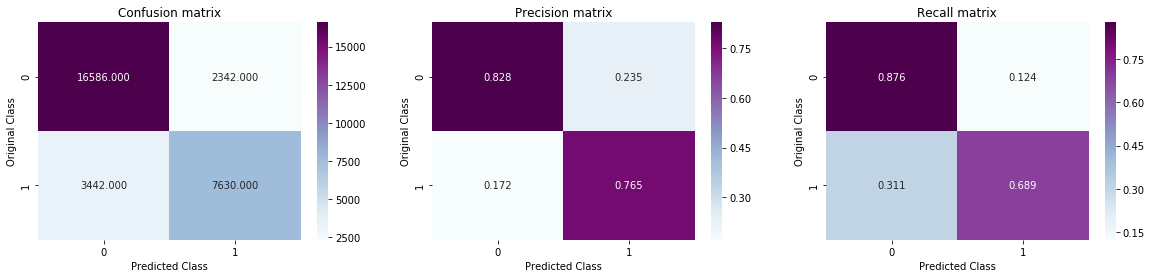

In [292]:
pred_y=model.predict_classes(lstm_test)
plot_confusion_matrix(y_test, pred_y)
# pred_y.shape,y_test.shape

<b> Check LSTM model on some test records 

In [286]:

for i in range(20):
    ques=[]
    index=X_test.index[i] 
    temp_y=X_test.loc[index,'is_duplicate']    
     
    ques.append(X_test.loc[index]['question1'].strip()) 
    Q1_temp = tokenizer.texts_to_sequences(ques)       
    Q1_temp = pad_sequences(Q1_temp,maxlen=50,padding='post')
    
    ques=[]
    ques.append(X_test.loc[index]['question2'].strip())
    Q2_temp = tokenizer.texts_to_sequences(ques) 
    Q2_temp = pad_sequences(Q2_temp,maxlen=50,padding='post')
 
    
    data_test_temp=pd.DataFrame(X_test.loc[index,~X_test.columns.isin(['id','is_duplicate','qid1','qid2','question1','question2'])]).T
     
    lstm_test_temp=np.concatenate((Q1_temp,Q2_temp,data_test_temp),axis=1) 
     
    predict=model.predict_classes(lstm_test_temp)
    predict_proba=model.predict(lstm_test_temp)
    print("Question 1:",X_test.loc[index]['question1'])
    print("Question 2:",X_test.loc[index]['question2'])
    print("Actual",temp_y,"Predicted",predict, "with probability",predict_proba[0][predict])
    print("\n")
    

Question 1: what are your views on ban of 500 and 1k rupee notes in india 
Question 2: what are the possible implications of demonetization of 500 and 1k rupee notes 
Actual 1 Predicted [1] with probability [0.9897198]


Question 1: does epsilon nfa has more computational power than dfa 
Question 2: does the e nfa have more computation than the dfa  justify 
Actual 1 Predicted [0] with probability [0.5747047]


Question 1: when will i get ssb call letter for nda 2 2016 
Question 2: when will i get the call letter for ssb of nda 2 2016 
Actual 1 Predicted [1] with probability [0.74092656]


Question 1: what is the personal property security act and how is nova scotia own different from newfoundland own 
Question 2: what is the personal property security act and how is nova scotia own different from british columbia own 
Actual 0 Predicted [0] with probability [0.83474344]


Question 1: can a tornado and hurricane happen at the same time   same place and create more than one in one day 


<b> Check by taking input of 2 questions

In [363]:
q1=input()
q2=input()
data={'question1':q1,'question2':q2,'qid1':1,'qid2':2}
Id= [1]
temp= pd.DataFrame(data,index=Id)
addBasicFeatures(temp)
temp = extract_features(temp) 

temp_tf_idf_test_q1= tfidf.transform(temp['question1'].values) 
temp_tf_idf_test_q2= tfidf.transform(temp['question2'].values) 
#Normalize the data
temp_normalize_q1 = normalize(temp_tf_idf_test_q1, axis=0) 
temp_normalize_q2 = normalize(temp_tf_idf_test_q2, axis=0) 
csrq1=temp_normalize_q1.tocsr()
csrq2=temp_normalize_q2.tocsr()
 
cosineTrain=[]
for i in range(0,csrq2.shape[0]):
    cosineTrain.append(cosine.cosine_similarity(csrq1[i],csrq2[i])[0][0]) 
 
temp['Cosine']=cosineTrain 

ques=[]   
ques.append(q1) 
Q1_temp = tokenizer.texts_to_sequences(ques)       
Q1_temp = pad_sequences(Q1_temp,maxlen=50,padding='post')

ques=[]
ques.append(q2)
Q2_temp = tokenizer.texts_to_sequences(ques) 
Q2_temp = pad_sequences(Q2_temp,maxlen=50,padding='post')


data_test_temp=pd.DataFrame(temp.loc[:,~temp.columns.isin(['Id','qid1','qid2','question1','question2'])])

lstm_test_temp=np.concatenate((Q1_temp,Q2_temp,data_test_temp),axis=1) 

predict=model.predict_classes(lstm_test_temp)
predict_proba=model.predict(lstm_test_temp) 
print("Predicted",predict, "with probability",predict_proba[0][predict])
print("\n")



When will i get the call letter for TCS interview ?
When will TCS send me the call letter for the interview ?
Predicted [1] with probability [0.64441544]




In [20]:
from keras.callbacks import ModelCheckpoint
batch_size=100
embed_dim = 128
lstm_out = 128
timesteps=8
# Model saving callback
 

model = Sequential()
model.add(Embedding(num_words, embed_dim, input_length = lstm_train.shape[1]))
model.add(LSTM(lstm_out,recurrent_dropout=0.5,dropout=0.5)) 
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])

filepath="./weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
print(model.summary())
history_ = model.fit(lstm_train, Y_Train, batch_size=128, epochs=90, verbose=1, 
                    validation_data=(lstm_test, Y_Test),callbacks=callbacks_list)                      

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 127, 128)          2560000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 2,691,842
Trainable params: 2,691,842
Non-trainable params: 0
_________________________________________________________________
None
Instructions for updating:
Use tf.cast instead.
Train on 70000 samples, validate on 30000 samples
Epoch 1/90
70000/70000 [==============================] - 412s 6ms/step - loss: 0.5003 - acc: 0.7282 - val

KeyboardInterrupt: 

loading the weights from model with best accuracy


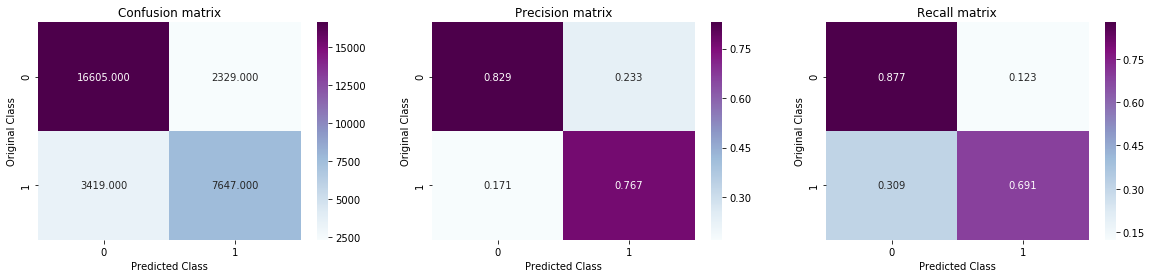

In [22]:
seed = 7
np.random.seed(seed)
print("loading the weights from model with best accuracy")
model.load_weights('./weights-improvement-11-0.81.hdf5')
pred_y=model.predict_classes(lstm_test)
plot_confusion_matrix(y_test, pred_y)
# pred_y.shape,y_test.shape

In [23]:

for i in range(20):
    ques=[]
    index=X_test.index[i] 
    temp_y=X_test.loc[index,'is_duplicate']    
     
    ques.append(X_test.loc[index]['question1'].strip()) 
    Q1_temp = tokenizer.texts_to_sequences(ques)       
    Q1_temp = pad_sequences(Q1_temp,maxlen=50,padding='post')
    
    ques=[]
    ques.append(X_test.loc[index]['question2'].strip())
    Q2_temp = tokenizer.texts_to_sequences(ques) 
    Q2_temp = pad_sequences(Q2_temp,maxlen=50,padding='post')
 
    
    data_test_temp=pd.DataFrame(X_test.loc[index,~X_test.columns.isin(['id','is_duplicate','qid1','qid2','question1','question2'])]).T
     
    lstm_test_temp=np.concatenate((Q1_temp,Q2_temp,data_test_temp),axis=1) 
     
    predict=model.predict_classes(lstm_test_temp)
    predict_proba=model.predict(lstm_test_temp)
    print("Question 1:",X_test.loc[index]['question1'])
    print("Question 2:",X_test.loc[index]['question2'])
    print("Actual",temp_y,"Predicted",predict, "with probability",predict_proba[0][predict])
    print("\n")
    

Question 1: how do i forget someone whom i have loved with all my heart 
Question 2: how do i forget someone i was deeply in love 
Actual 1 Predicted [1] with probability [0.92897755]


Question 1: what is the sahara  and how do the average temperatures there compare to the ones in the colorado plateau 
Question 2: what is the sahara  and how do the average temperatures there compare to the ones in the mojave desert 
Actual 1 Predicted [1] with probability [0.9828745]


Question 1: how long will my jaundice last 
Question 2: how long does jaundice last 
Actual 1 Predicted [1] with probability [0.5847505]


Question 1: how do you write a cursive capital  q  
Question 2: how do i write a  q  in cursive 
Actual 0 Predicted [0] with probability [0.6753162]


Question 1: what are the vegan cafe 
Question 2: do you have to be vegan to work at a vegan cafe 
Actual 0 Predicted [0] with probability [0.9224422]


Question 1: what is a good inpatient drug and alcohol rehab center in allamakee cou

In [25]:
q1=input()
q2=input()
data={'question1':q1,'question2':q2,'qid1':1,'qid2':2}
Id= [1]
temp= pd.DataFrame(data,index=Id)
addBasicFeatures(temp)
temp = extract_features(temp) 

temp_tf_idf_test_q1= tfidf.transform(temp['question1'].values) 
temp_tf_idf_test_q2= tfidf.transform(temp['question2'].values) 
#Normalize the data
temp_normalize_q1 = normalize(temp_tf_idf_test_q1, axis=0) 
temp_normalize_q2 = normalize(temp_tf_idf_test_q2, axis=0) 
csrq1=temp_normalize_q1.tocsr()
csrq2=temp_normalize_q2.tocsr()
 
cosineTrain=[]
for i in range(0,csrq2.shape[0]):
    cosineTrain.append(cosine.cosine_similarity(csrq1[i],csrq2[i])[0][0]) 
 
temp['Cosine']=cosineTrain 

ques=[]   
ques.append(q1) 
Q1_temp = tokenizer.texts_to_sequences(ques)       
Q1_temp = pad_sequences(Q1_temp,maxlen=50,padding='post')

ques=[]
ques.append(q2)
Q2_temp = tokenizer.texts_to_sequences(ques) 
Q2_temp = pad_sequences(Q2_temp,maxlen=50,padding='post')


data_test_temp=pd.DataFrame(temp.loc[:,~temp.columns.isin(['Id','qid1','qid2','question1','question2'])])

lstm_test_temp=np.concatenate((Q1_temp,Q2_temp,data_test_temp),axis=1) 

predict=model.predict_classes(lstm_test_temp)
predict_proba=model.predict(lstm_test_temp) 
print("Predicted",predict, "with probability",predict_proba[0][predict])
print("\n")



Why apple's color is red?
Apple's color is red, why?
Predicted [1] with probability [0.59178543]




<h1><b> Summary of all the models

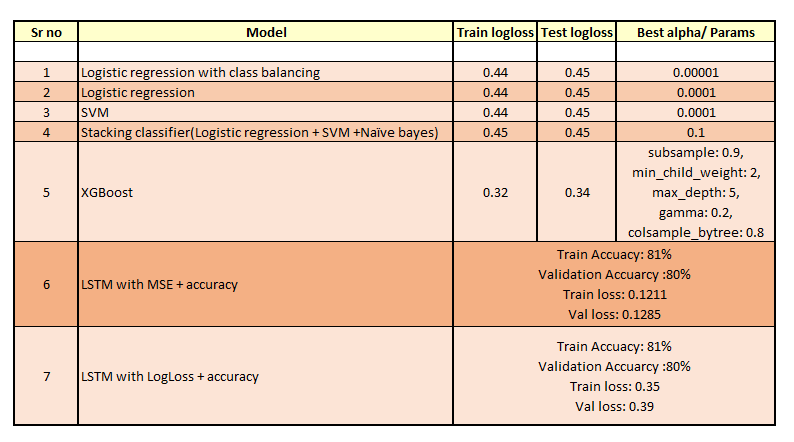
